In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
  At

In [ ]:
import os
from tensorflow import keras
from google.colab import drive
from datetime import datetime
from matplotlib.ticker import MaxNLocator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, Accuracy, MeanIoU
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
# Mount the google drive in notebook sources
drive.mount('/content/drive')

!mkdir data
!cp -r "/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/data/augmented/test" "/content/data/test"
!cp -r "/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/data/augmented/val" "/content/data/val"

# Base path to the processed HRSID data
base_path = '/content/data/'

# Path to all saved models
models_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models'

Mounted at /content/drive


In [ ]:
class SARDataGenerator(Sequence):
    """
    Data generator for loading and processing images and masks on the fly.
    This class is derived from Keras's Sequence class to efficiently handle
    batching in multi-threaded environments.
    """

    def __init__(self, image_filenames, masks_filenames, batch_size, target_size, augmentations=None):
        """
        Initialize the data generator instance.
        """
        self.image_filenames = image_filenames
        self.masks_filenames = masks_filenames
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations

        if augmentations is not None:
            self.datagen = ImageDataGenerator(**augmentations)
        else:
            self.datagen = ImageDataGenerator()

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        """
        Generate one batch of data.
        """
        # Slice the file paths to generate the batch
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.masks_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Load and process the images and masks
        images = [self.process_image(file_name) for file_name in batch_x]
        masks = [self.process_mask(file_name) for file_name in batch_y]

        # Augment the images and masks
        seed = np.random.randint(0, 10000)
        images = next(self.datagen.flow(np.array(images), batch_size=self.batch_size, seed=seed))
        masks = next(self.datagen.flow(np.array(masks), batch_size=self.batch_size, seed=seed))

        return images, masks

    def process_image(self, file_name):
        """
        Load and process an image file.
        """
        # Load the image, resize it, and convert to grayscale if necessary
        if len(self.target_size) == 3 and self.target_size[2] == 3:
            image = load_img(file_name, target_size=self.target_size, color_mode='rgb')
        else:
            image = load_img(file_name, target_size=self.target_size, color_mode='grayscale')
        # Convert the image to a numpy array and normalize it to [0, 1]
        image = img_to_array(image) / 255.0

        return image

    def process_mask(self, file_name):
        """
        Load and process a mask file.
        """
        # Load the mask, resize it, and convert to grayscale
        mask = load_img(file_name, target_size=self.target_size, color_mode="grayscale")
        # Convert the mask to a numpy array and normalize it  to [0, 1]
        mask = img_to_array(mask) / 255.0

        return mask


In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [ ]:
model_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-07-23_20-45-00/unet_best_val_iou.keras'
history_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-07-23_20-45-00/training_history.pkl'

# Load the saved model
# saved_model = load_model(model_path, custom_objects={'dice_loss': dice_loss})

# Load the saved history
with open(history_path, 'rb') as file:
    saved_history = pickle.load(file)

In [ ]:
saved_model.summary()

NameError: name 'saved_model' is not defined

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(saved_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_training_history(hist_dict):
    # Define the metrics and loss categories to plot
    metrics = ['precision', 'recall', 'mean_io_u']
    loss = ['loss']

    # Plot metrics in one horizontal figure
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 6*3 for each subplot to give sufficient width
    # fig.suptitle("Metrics and Loss over epochs")

    for idx, metric in enumerate(metrics):
        # Check if corresponding validation data exists
        train_metric = metric if metric in hist_dict else None
        val_metric = 'val_' + metric if 'val_' + metric in hist_dict else None

        if train_metric:
            y_values = hist_dict[train_metric]
            x_values = range(1, len(y_values) + 1)
            axs[idx%2, idx//2].plot(x_values, y_values, label="Training", color='#e600e6', marker='o', linewidth=2)

        if val_metric:
            y_values = hist_dict[val_metric]
            axs[idx%2, idx//2].plot(x_values, y_values, label="Validation", color='#e6e600', marker='o', linewidth=2)

        axs[idx%2, idx//2].set_title(metric.capitalize() if metric!="mean_io_u" else "Mean IoU")
        axs[idx%2, idx//2].set_xlabel('epoka')
        axs[idx%2, idx//2].set_ylabel('wartość metryki')
        axs[idx%2, idx//2].set_xticks(range(1, len(y_values) + 1, 2))
        # axs[idx%2, idx//2].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[idx%2, idx//2].legend()
        axs[idx%2, idx//2].grid()


    train_loss = loss[0] if loss[0] in hist_dict else None
    val_loss = 'val_' + loss[0] if 'val_' + loss[0] in hist_dict else None

    if train_loss:
        y_values = hist_dict[train_loss]
        x_values = range(1, len(y_values) + 1)
        axs[1, 1].plot(x_values, y_values, label="Training", color='#e600e6', marker='o', linewidth=2)

    if val_loss:
        y_values = hist_dict[val_loss]
        axs[1, 1].plot(x_values, y_values, label="Validation", color='#e6e600', marker='o', linewidth=2)

    axs[1, 1].set_title('Dice loss')
    axs[1, 1].set_xlabel('epoka')
    axs[1, 1].set_ylabel('wartość straty')
    axs[1, 1].set_xticks(range(1, len(y_values) + 1, 2))
    # axs[1, 1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1, 1].legend()
    axs[1, 1].grid()

    plt.show()

In [ ]:
print("Data categories from model training: ", list(saved_history.keys()), "\n")
plot_training_history(saved_history)

In [ ]:
TARGET_SHAPE = (512, 512, 3)
BATCH_SIZE = 8

In [ ]:
import json

# Read JSON file with annotations
with open('inshore.json', 'r') as file:
    inshore_data_coco = json.load(file)

with open('offshore.json', 'r') as file:
    offshore_data_coco = json.load(file)

# List for image names
inshore_image_names = [image_info['file_name'] for image_info in inshore_data_coco['images']]
offshore_image_names = [image_info['file_name'] for image_info in offshore_data_coco['images']]

test_image_names = sorted(os.listdir(os.path.join(base_path, 'test', 'images')))
val_image_names = sorted(os.listdir(os.path.join(base_path, 'val', 'images')))
test_mask_names = sorted(os.listdir(os.path.join(base_path, 'test', 'masks')))
val_mask_names = sorted(os.listdir(os.path.join(base_path, 'val', 'masks')))

in_img = []
off_img = []
in_mask = []
off_mask = []

for image_name, mask_name in zip(test_image_names, test_mask_names):
    if image_name in inshore_image_names:
        in_img.append(os.path.join(base_path, 'test', 'images', image_name))
        in_mask.append(os.path.join(base_path, 'test', 'masks', mask_name))
    elif image_name in offshore_image_names:
        if len(off_img) < len(in_img):
            off_img.append(os.path.join(base_path, 'test', 'images', image_name))
            off_mask.append(os.path.join(base_path, 'test', 'masks', mask_name))

in_count = len(in_img)
off_count = len(off_img)
print("in = {} off = {} all = {}".format(in_count, off_count, in_count + off_count))

for image_name, mask_name in zip(val_image_names, val_mask_names):
    if image_name in inshore_image_names:
        in_img.append(os.path.join(base_path, 'val', 'images', image_name))
        in_mask.append(os.path.join(base_path, 'val', 'masks', mask_name))
    elif image_name in offshore_image_names:
        if len(off_img) < len(in_img):
            off_img.append(os.path.join(base_path, 'val', 'images', image_name))
            off_mask.append(os.path.join(base_path, 'val', 'masks', mask_name))

in_count = len(in_img)
off_count = len(off_img)
print("in = {} off = {} all = {}".format(in_count, off_count, in_count + off_count))

inshore_gen = SARDataGenerator(image_filenames=in_img, masks_filenames=in_mask, batch_size=BATCH_SIZE, target_size=TARGET_SHAPE)

inshore_images_loaded = np.array([inshore_gen.process_image(f) for f in in_img])
inshore_masks_loaded = np.array([inshore_gen.process_mask(f) for f in in_mask])

offshore_gen = SARDataGenerator(image_filenames=off_img, masks_filenames=off_mask, batch_size=BATCH_SIZE, target_size=TARGET_SHAPE)

offshore_images_loaded = np.array([offshore_gen.process_image(f) for f in off_img])
offshore_masks_loaded = np.array([offshore_gen.process_mask(f) for f in off_mask])

In [ ]:
in_results = saved_model.evaluate(inshore_gen, batch_size=16)
print(in_results)
in_predictions = saved_model.predict(inshore_images_loaded, batch_size=16)

In [ ]:
off_results = saved_model.evaluate(offshore_gen, batch_size=16)
print(off_results)
off_predictions = saved_model.predict(offshore_images_loaded, batch_size=16)

In [ ]:
test_images_dir = os.path.join(base_path, 'test', 'images')
test_masks_dir = os.path.join(base_path, 'test', 'masks')
test_images = [os.path.join(test_images_dir, f) for f in sorted(os.listdir(test_images_dir))]
test_masks = [os.path.join(test_masks_dir, f) for f in sorted(os.listdir(test_masks_dir))]

test_gen = SARDataGenerator(image_filenames=test_images, masks_filenames=test_masks, batch_size=BATCH_SIZE, target_size=TARGET_SHAPE)

test_images_loaded = np.array([test_gen.process_image(f) for f in test_images])
test_masks_loaded = np.array([test_gen.process_mask(f) for f in test_masks])

In [ ]:
results = saved_model.evaluate(test_gen, batch_size=16)
print(results)
predictions = saved_model.predict(test_images_loaded, batch_size=16)

In [ ]:
def visualize_predictions(image_batch, mask_batch, prediction_batch, num_samples=3):
    # Ensure that the number of samples does not exceed the batch size
    num_samples = min(num_samples, len(image_batch))

    # Randomly select indices for the images to display
    indices = np.random.randint(0, len(image_batch), num_samples)

    fig, axs = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))
    for i, idx in enumerate(indices):
        axs[i, 0].imshow(image_batch[idx, :, :, 0], cmap='gray')
        axs[i, 0].title.set_text('Original Image')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(mask_batch[idx, :, :, 0], cmap='gray')
        axs[i, 1].title.set_text('True Mask')
        axs[i, 1].axis('off')
        axs[i, 2].imshow(prediction_batch[idx, :, :, 0] > 0.5, cmap='gray')  # Thresholding prediction
        axs[i, 2].title.set_text('Predicted Mask')
        axs[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_predictions(inshore_images_loaded, inshore_masks_loaded, in_predictions, 9)

In [ ]:
# Assume 'predictions' contains the model's outputs for the corresponding test images
visualize_predictions(offshore_images_loaded, offshore_masks_loaded, off_predictions, 9)

In [ ]:
test1_gen = SARDataGenerator(image_filenames=test_images, masks_filenames=test_masks, batch_size=BATCH_SIZE, target_size=(512, 512, 1))
test2_gen = SARDataGenerator(image_filenames=test_images, masks_filenames=test_masks, batch_size=BATCH_SIZE, target_size=(512, 512, 3))

In [ ]:
im_path = os.path.join(base_path, 'test', 'images', 'P0108_2400_3200_7200_8000.jpg')
ma_path = os.path.join(base_path, 'test', 'masks', 'P0108_2400_3200_7200_8000.png')

im1_loaded = np.array([test1_gen.process_image(im_path)])
ma1_loaded = np.array([test1_gen.process_mask(ma_path)])

im2_loaded = np.array([test2_gen.process_image(im_path)])
ma2_loaded = np.array([test2_gen.process_mask(ma_path)])

In [ ]:
mod1_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-07-20_14-44-17/unet_best_val_loss.keras'
mod2_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-07-21_09-18-01/unet_best_val_loss.keras'
mod3_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-07-23_18-51-15/unet_best_val_recall.keras'
mod4_path = '/content/drive/MyDrive/Studia/SAR_Ship_Segmentation/models/Sesja z 2024-07-23_20-45-00/unet_best_val_iou.keras'

mod1 = load_model(mod1_path, custom_objects={'dice_loss': dice_loss})
mod2 = load_model(mod2_path, custom_objects={'dice_loss': dice_loss})
mod3 = load_model(mod3_path, custom_objects={'dice_loss': dice_loss})
mod4 = load_model(mod4_path, custom_objects={'dice_loss': dice_loss})

In [ ]:
mod1_pred = mod1.predict(im1_loaded, batch_size=1)
mod2_pred = mod2.predict(im2_loaded, batch_size=1)
mod3_pred = mod3.predict(im2_loaded, batch_size=1)
mod4_pred = mod4.predict(im2_loaded, batch_size=1)

1/1 [==============================] - 1s 768ms/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def compare_single_prediction(true_img, true_mask, pred1_mask, pred2_mask, pred3_mask, pred4_mask, threshold=0.5):
    # def create_colored_mask(pred_mask, true_mask):
    #     # Create an empty array for the color mask (3 channels for RGB)
    #     color_mask = np.zeros((true_mask.shape[0], true_mask.shape[1], 3), dtype=np.uint8)

    #     # Threshold the predicted mask
    #     pred_mask_bin = np.squeeze(pred_mask > threshold)
    #     true_mask = np.squeeze(true_mask)

    #     # True Positives: Correctly predicted as object (1) -> White
    #     true_positives = (pred_mask_bin == 1) & (true_mask == 1)
    #     color_mask[true_positives] = [255, 255, 255]  # White (R=255, G=255, B=255)

    #     # False Positives: Predicted as object (1) but actually background (0) -> Red
    #     false_positives = (pred_mask_bin == 1) & (true_mask == 0)
    #     color_mask[false_positives, 0] = 100  # Red channel

    #     # False Negatives: Predicted as background (0) but actually object (1) -> Green
    #     false_negatives = (pred_mask_bin == 0) & (true_mask == 1)
    #     color_mask[false_negatives, 1] = 100  # Green channel

    #     return color_mask

    # Create a figure
    fig = plt.figure(figsize=(12, 9))

    # Create a GridSpec with 3 rows and 4 columns
    gs = GridSpec(3, 4, figure=fig)

    # Plot the true image (occupying 2 columns in the first row)
    ax1 = fig.add_subplot(gs[:2, :2])
    ax1.imshow(true_img[0], cmap='gray')
    ax1.set_title('Zdjęcie SAR')
    ax1.axis('off')

    # Plot the true mask (occupying 2 columns in the first row)
    ax2 = fig.add_subplot(gs[:2, 2:])
    ax2.imshow(true_mask[0], cmap='gray')
    ax2.set_title('Prawdziwa maska')
    ax2.axis('off')

    # Apply the color mapping to the predicted masks
    # colored_pred1 = create_colored_mask(pred1_mask[0], true_mask[0])
    # colored_pred2 = create_colored_mask(pred2_mask[0], true_mask[0])
    # colored_pred3 = create_colored_mask(pred3_mask[0], true_mask[0])
    # colored_pred4 = create_colored_mask(pred4_mask[0], true_mask[0])

    # Plot the predicted masks with the color overlay
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.imshow(pred1_mask[0], cmap='gray')
    ax3.set_title('Maska UNetAug')
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[2, 1])
    ax4.imshow(pred2_mask[0], cmap='gray')
    ax4.set_title('Maska UNetResAug')
    ax4.axis('off')

    ax5 = fig.add_subplot(gs[2, 2])
    ax5.imshow(pred3_mask[0], cmap='gray')
    ax5.set_title('Maska UNetResSP1')
    ax5.axis('off')

    ax6 = fig.add_subplot(gs[2, 3])
    ax6.imshow(pred4_mask[0], cmap='gray')
    ax6.set_title('Maska UNetResSP2')
    ax6.axis('off')

    # Adjust the layout to make it clean
    plt.tight_layout()
    plt.show()

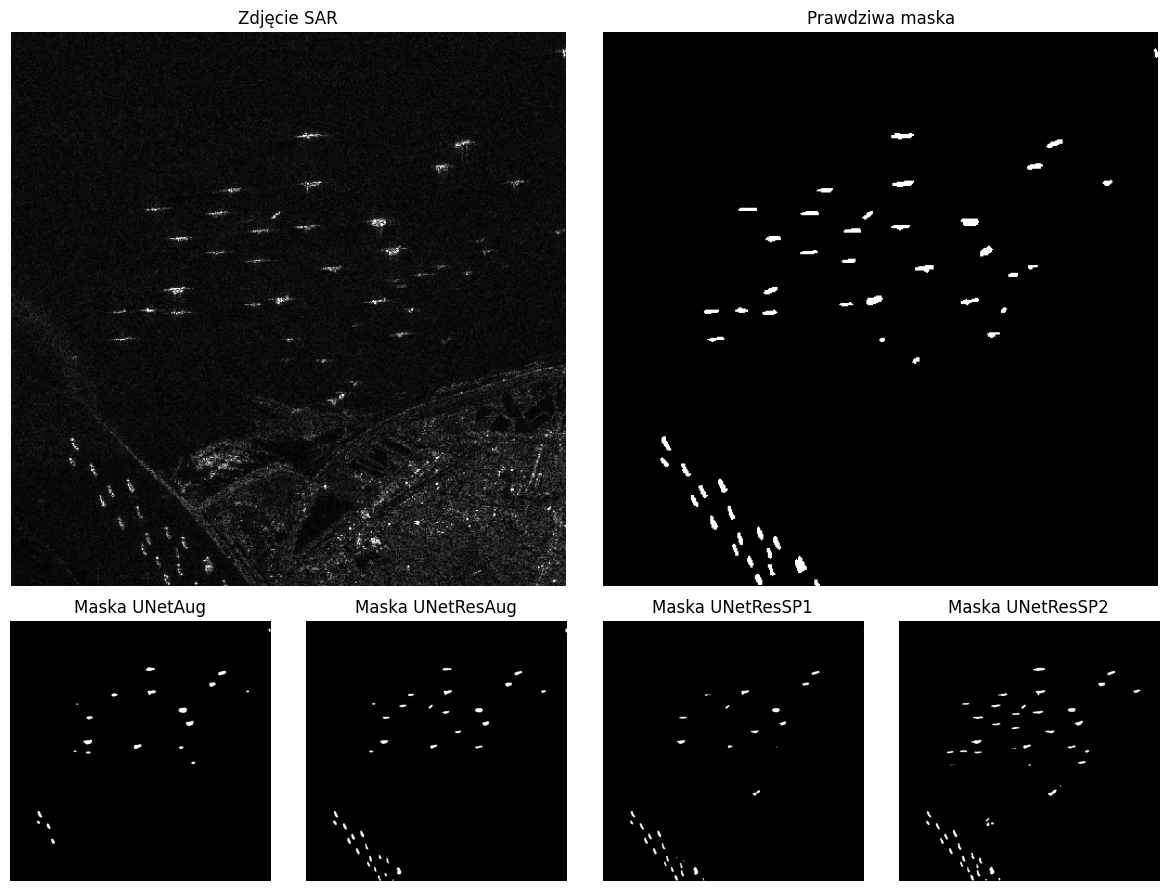

In [ ]:
compare_single_prediction(im1_loaded, ma1_loaded, mod1_pred, mod2_pred, mod3_pred, mod4_pred)

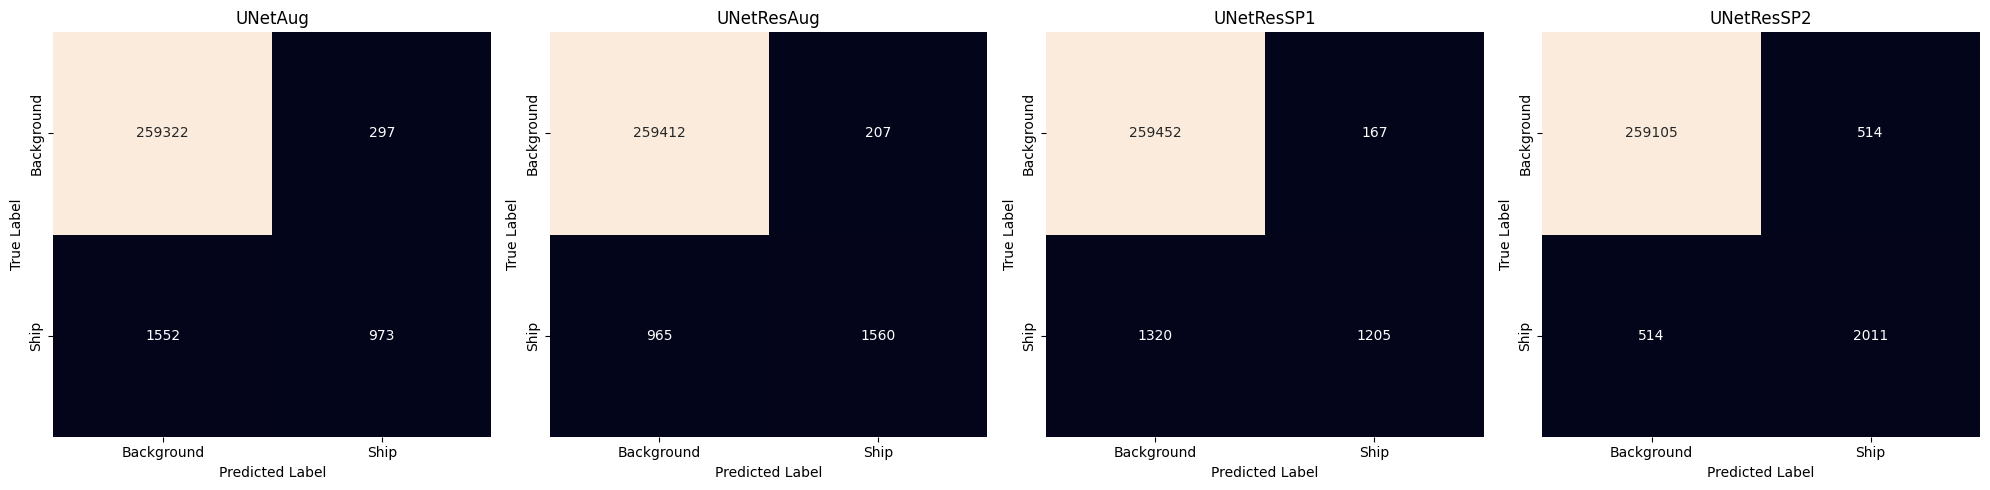

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(true_mask, pred1_mask, pred2_mask, pred3_mask, pred4_mask, class_names):
    def compute_confusion_matrix(y_true, y_pred):
        y_pred_binary = (y_pred > 0.5).astype(int)  # Assuming 0.5 as the threshold
        return confusion_matrix(y_true.flatten(), y_pred_binary.flatten())

    # Compute confusion matrices for each predicted mask
    conf_matrix1 = compute_confusion_matrix(true_mask, pred1_mask)
    conf_matrix2 = compute_confusion_matrix(true_mask, pred2_mask)
    conf_matrix3 = compute_confusion_matrix(true_mask, pred3_mask)
    conf_matrix4 = compute_confusion_matrix(true_mask, pred4_mask)

    # Plot confusion matrices
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    sns.heatmap(conf_matrix1, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, ax=axs[0], cbar=False)
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('True Label')
    axs[0].set_title('UNetAug')

    sns.heatmap(conf_matrix2, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, ax=axs[1], cbar=False)
    axs[1].set_xlabel('Predicted Label')
    axs[1].set_ylabel('True Label')
    axs[1].set_title('UNetResAug')

    sns.heatmap(conf_matrix3, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, ax=axs[2], cbar=False)
    axs[2].set_xlabel('Predicted Label')
    axs[2].set_ylabel('True Label')
    axs[2].set_title('UNetResSP1')

    sns.heatmap(conf_matrix4, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, ax=axs[3], cbar=False)
    axs[3].set_xlabel('Predicted Label')
    axs[3].set_ylabel('True Label')
    axs[3].set_title('UNetResSP2')

    plt.tight_layout()
    plt.show()


# Example usage:
plot_confusion_matrices(ma1_loaded, mod1_pred, mod2_pred, mod3_pred, mod4_pred, class_names=['Background', 'Ship'])

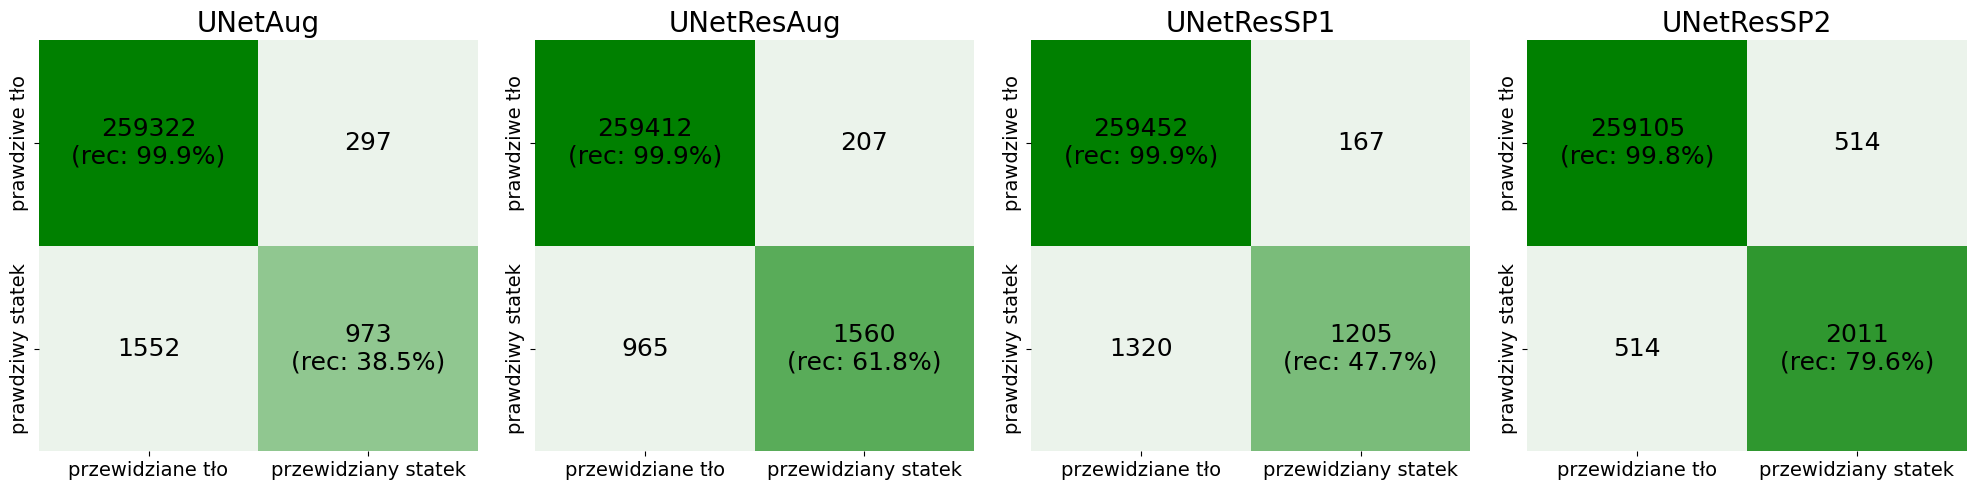

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# def plot_confusion_matrices(true_mask, pred1_mask, pred2_mask, pred3_mask, pred4_mask, class_names):
#     def compute_confusion_matrix(y_true, y_pred):
#         y_pred_binary = (y_pred > 0.5).astype(int)  # Assuming 0.5 as the threshold
#         cm = confusion_matrix(y_true.flatten(), y_pred_binary.flatten())

#         # Normalize the confusion matrix to get proportions for TP and TN
#         cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#         # Prepare the final color matrix, starting with TP and TN
#         cm_colored = np.zeros_like(cm_normalized)
#         cm_colored[0, 0] = cm_normalized[0, 0]  # TN block
#         cm_colored[1, 1] = cm_normalized[1, 1]  # TP block

#         # Assign a constant low value for FP and FN to keep them black
#         cm_colored[0, 1] = 0  # FN block (black color)
#         cm_colored[1, 0] = 0  # FP block (black color)

#         return cm_colored, cm, cm_normalized

#     def annotate_heatmap(ax, cm, cm_normalized, fontsize=12):
#         for i in range(cm.shape[0]):
#             for j in range(cm.shape[1]):
#                 if (i == 0 and j == 0) or (i == 1 and j == 1):  # TN or TP
#                     percentage = f"recall: {cm_normalized[i, j] * 100:.1f}%"
#                     annotation = f"{cm[i, j]}\n({percentage})"
#                 else:  # FP or FN
#                     annotation = f"{cm[i, j]}"
#                 ax.text(j + 0.5, i + 0.5, annotation,
#                         ha='center', va='center', color='black', fontsize=fontsize)

#     # Compute confusion matrices for each predicted mask
#     conf_matrix1, raw_cm1, cm_normalized1 = compute_confusion_matrix(true_mask, pred1_mask)
#     conf_matrix2, raw_cm2, cm_normalized2 = compute_confusion_matrix(true_mask, pred2_mask)
#     conf_matrix3, raw_cm3, cm_normalized3 = compute_confusion_matrix(true_mask, pred3_mask)
#     conf_matrix4, raw_cm4, cm_normalized4 = compute_confusion_matrix(true_mask, pred4_mask)

#     # Plot confusion matrices
#     fig, axs = plt.subplots(2, 2, figsize=(10, 10))

#     # Use the "Greens" colormap for TP and TN
#     cmap = sns.light_palette("green", as_cmap=True)

#     sns.heatmap(conf_matrix1, xticklabels=class_names, yticklabels=class_names, ax=axs[0, 0], cmap=cmap, cbar=False, annot=False)
#     annotate_heatmap(axs[0, 0], raw_cm1, cm_normalized1, fontsize=16)
#     axs[0, 0].set_xlabel('Przewidziana etykieta')
#     axs[0, 0].set_ylabel('Prawdziwa etykieta')
#     axs[0, 0].set_title('UNetAug')

#     sns.heatmap(conf_matrix2, xticklabels=class_names, yticklabels=class_names, ax=axs[0, 1], cmap=cmap, cbar=False, annot=False)
#     annotate_heatmap(axs[0, 1], raw_cm2, cm_normalized2, fontsize=16)
#     axs[0, 1].set_xlabel('Przewidziana etykieta')
#     axs[0, 1].set_ylabel('Prawdziwa etykieta')
#     axs[0, 1].set_title('UNetResAug')

#     sns.heatmap(conf_matrix3, xticklabels=class_names, yticklabels=class_names, ax=axs[1, 0], cmap=cmap, cbar=False, annot=False)
#     annotate_heatmap(axs[1, 0], raw_cm3, cm_normalized3, fontsize=16)
#     axs[1, 0].set_xlabel('Przewidziana etykieta')
#     axs[1, 0].set_ylabel('Prawdziwa etykieta')
#     axs[1, 0].set_title('UNetResSP1')

#     sns.heatmap(conf_matrix4, xticklabels=class_names, yticklabels=class_names, ax=axs[1, 1], cmap=cmap, cbar=False, annot=False)
#     annotate_heatmap(axs[1, 1], raw_cm4, cm_normalized4, fontsize=16)
#     axs[1, 1].set_xlabel('Przewidziana etykieta')
#     axs[1, 1].set_ylabel('Prawdziwa etykieta')
#     axs[1, 1].set_title('UNetResSP2')

#     plt.tight_layout()
#     plt.show()


def plot_confusion_matrices(true_mask, pred1_mask, pred2_mask, pred3_mask, pred4_mask):
    def compute_confusion_matrix(y_true, y_pred):
        y_pred_binary = (y_pred > 0.5).astype(int)  # Assuming 0.5 as the threshold
        cm = confusion_matrix(y_true.flatten(), y_pred_binary.flatten())

        # Normalize the confusion matrix to get proportions for TP and TN
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Prepare the final color matrix, starting with TP and TN
        cm_colored = np.zeros_like(cm_normalized)
        cm_colored[0, 0] = cm_normalized[0, 0]  # TN block
        cm_colored[1, 1] = cm_normalized[1, 1]  # TP block

        # Assign a constant low value for FP and FN to keep them black
        cm_colored[0, 1] = 0  # FN block (black color)
        cm_colored[1, 0] = 0  # FP block (black color)

        return cm_colored, cm, cm_normalized

    def annotate_heatmap(ax, cm, cm_normalized, fontsize=12):
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                if (i == 0 and j == 0) or (i == 1 and j == 1):  # TN or TP
                    percentage = f"rec: {cm_normalized[i, j] * 100:.1f}%"
                    annotation = f"{cm[i, j]}\n({percentage})"
                else:  # FP or FN
                    annotation = f"{cm[i, j]}"
                ax.text(j + 0.5, i + 0.5, annotation,
                        ha='center', va='center', color='black', fontsize=fontsize)

    # Compute confusion matrices for each predicted mask
    conf_matrix1, raw_cm1, cm_normalized1 = compute_confusion_matrix(true_mask, pred1_mask)
    conf_matrix2, raw_cm2, cm_normalized2 = compute_confusion_matrix(true_mask, pred2_mask)
    conf_matrix3, raw_cm3, cm_normalized3 = compute_confusion_matrix(true_mask, pred3_mask)
    conf_matrix4, raw_cm4, cm_normalized4 = compute_confusion_matrix(true_mask, pred4_mask)

    # Custom class labels
    x_class_names = ['przewidziane tło', 'przewidziany statek']
    y_class_names = ['prawdziwe tło', 'prawdziwy statek']

    # Plot confusion matrices
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Use the "Greens" colormap for TP and TN
    cmap = sns.light_palette("green", as_cmap=True)

    labelsize = 14
    titlesize = 20
    othersize = 18

    sns.heatmap(conf_matrix1, xticklabels=x_class_names, yticklabels=y_class_names, ax=axs[0], cmap=cmap, cbar=False, annot=False)
    annotate_heatmap(axs[0], raw_cm1, cm_normalized1, fontsize=othersize)
    axs[0].set_title('UNetAug', fontsize=titlesize)
    axs[0].tick_params(axis='x', labelsize=labelsize)
    axs[0].tick_params(axis='y', labelsize=labelsize)

    sns.heatmap(conf_matrix2, xticklabels=x_class_names, yticklabels=y_class_names, ax=axs[1], cmap=cmap, cbar=False, annot=False)
    annotate_heatmap(axs[1], raw_cm2, cm_normalized2, fontsize=othersize)
    axs[1].set_title('UNetResAug', fontsize=titlesize)
    axs[1].tick_params(axis='x', labelsize=labelsize)
    axs[1].tick_params(axis='y', labelsize=labelsize)

    sns.heatmap(conf_matrix3, xticklabels=x_class_names, yticklabels=y_class_names, ax=axs[2], cmap=cmap, cbar=False, annot=False)
    annotate_heatmap(axs[2], raw_cm3, cm_normalized3, fontsize=othersize)
    axs[2].set_title('UNetResSP1', fontsize=titlesize)
    axs[2].tick_params(axis='x', labelsize=labelsize)
    axs[2].tick_params(axis='y', labelsize=labelsize)

    sns.heatmap(conf_matrix4, xticklabels=x_class_names, yticklabels=y_class_names, ax=axs[3], cmap=cmap, cbar=False, annot=False)
    annotate_heatmap(axs[3], raw_cm4, cm_normalized4, fontsize=othersize)
    axs[3].set_title('UNetResSP2', fontsize=titlesize)
    axs[3].tick_params(axis='x', labelsize=labelsize)
    axs[3].tick_params(axis='y', labelsize=labelsize)

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_confusion_matrices(ma1_loaded, mod1_pred, mod2_pred, mod3_pred, mod4_pred, class_names=['tło', 'statek'])

plot_confusion_matrices(ma1_loaded, mod1_pred, mod2_pred, mod3_pred, mod4_pred)

In [ ]:
import cv2
import numpy as np
from skimage import io, img_as_float
from skimage.filters import threshold_sauvola

def binarize_sar_image(image, method='adaptive'):
    """
    Binarizes a SAR image using the specified method.

    Parameters:
        image (numpy.ndarray): Input SAR image in grayscale.
        method (str): Binarization method to use ('adaptive' or 'sauvola').

    Returns:
        binary_image (numpy.ndarray): Binarized image.
    """
    image = cv2.GaussianBlur(image, (5, 5), 0)
    if method == 'adaptive':
        # Adaptive Thresholding using OpenCV

        binary_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                             cv2.THRESH_BINARY, blockSize=17, C=-15)
    elif method == 'sauvola':
        # Sauvola's Method using scikit-image
        # Convert image to float and apply Sauvola

        image_float = img_as_float(image)
        sauvola_thresh = threshold_sauvola(image_float, window_size=21, k=0.2)
        binary_image = image_float > sauvola_thresh
        binary_image = (binary_image * 255).astype(np.uint8)
    elif method == "otsu":
        _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == "manual":
        _, binary_image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
    else:
        raise ValueError("Unsupported method. Choose 'adaptive' or 'sauvola'.")

    return binary_image


In [ ]:
# Binarize using Adaptive Thresholding
image = load_img(im_path, target_size=(512, 512, 1), color_mode='grayscale')
# Convert the image to a numpy array and normalize it to [0, 1]
image = img_to_array(image).astype(np.uint8)

binary_adaptive = binarize_sar_image(image, method='adaptive')

# Binarize using Sauvola's Method
binary_sauvola = binarize_sar_image(image, method='sauvola')

binary_otsu = binarize_sar_image(image, method='otsu')

binary_manual = binarize_sar_image(image, method='manual')

# Display the results


In [ ]:
def compare_binearization(true_img, true_mask, pred_mask, bin1_mask, bin2_mask, threshold=0.5):
    # Create a figure
    fig = plt.figure(figsize=(12, 12))

    # Create a GridSpec with 3 rows and 4 columns
    gs = GridSpec(3, 6, figure=fig)

    # Plot the true image (occupying 2 columns in the first row)
    ax1 = fig.add_subplot(gs[:2, :3])
    ax1.imshow(true_img, cmap='gray')
    ax1.set_title('Zdjęcie SAR')
    ax1.axis('off')

    # Plot the true mask (occupying 2 columns in the first row)
    ax2 = fig.add_subplot(gs[:2, 3:])
    ax2.imshow(true_mask[0], cmap='gray')
    ax2.set_title('Prawdziwa maska')
    ax2.axis('off')

    # Plot the predicted masks with the color overlay
    ax3 = fig.add_subplot(gs[2, :2])
    ax3.imshow(bin1_mask, cmap='gray')
    ax3.set_title('Progowanie adaptacyjne')
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[2, 2:4])
    ax4.imshow(bin2_mask, cmap='gray')
    ax4.set_title('Progowanie metodą Otsu')
    ax4.axis('off')

    ax5 = fig.add_subplot(gs[2, 4:])
    ax5.imshow(pred_mask[0], cmap='gray')
    ax5.set_title('Predykcja UNetResSP2')
    ax5.axis('off')

    # Adjust the layout to make it clean
    plt.tight_layout()
    plt.show()

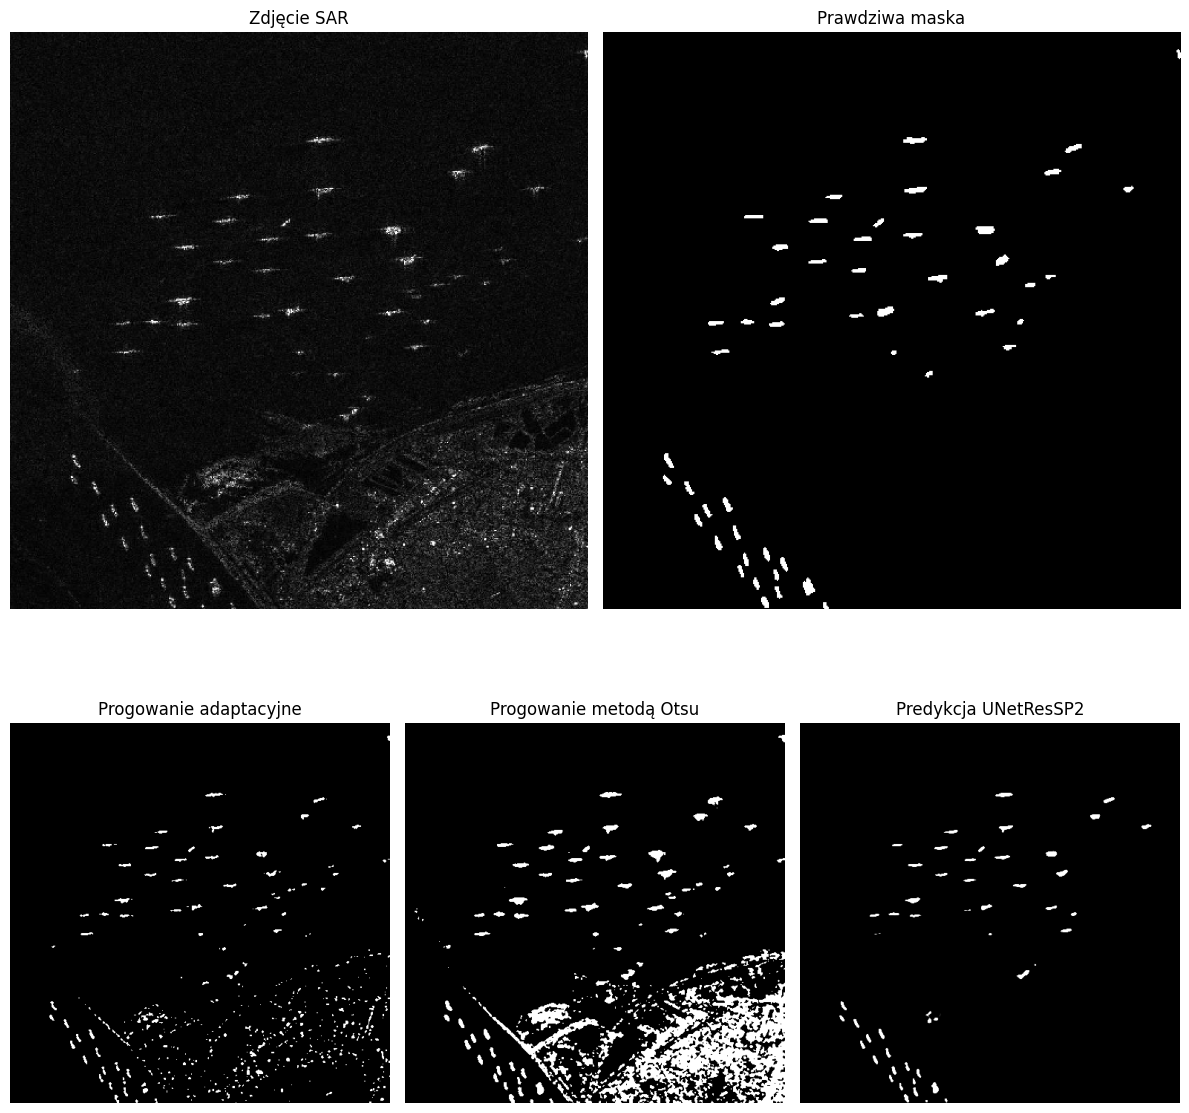

In [ ]:
compare_binearization(image, ma1_loaded, mod4_pred, binary_adaptive, binary_otsu)